#Executive Summary: **Bitcoin Trading**

In this project, I have built a trading strategy that uses machine learning to indicate a good time to buy bitcoin.

The strategy produces 200% in total returns on capital invested over the test period, with a win rate of 53%

One of the major challenges is defining a target variable that will capture enough buying opportunities for the model to be effective.

In addition, once the model is build, it is essential that I can set effective take profit and stop loss thresholds, and probability of target thresholds to maximize return.

  The steps that I will take are:

*   Choose a Take Profit, Stop Loss, Holding Period Setting to use to define a Target Variable
*   Build a model
*   Define a strategy/ optimal thresholds


A couple of things to note:



*   I have saved my work at various checkpoints
*   I have provided the initial dataset, 'Max_Data'
*   For computational effeciency, you can load corresponding data from each section from **Github** [Project Github](https://github.com/maxhtx/Bitcoin-Trading-Strategy.git) at these checkpoints
*   Sqlite queries, grid searches may take a while to run



## Table of Contents

>[Executive Summary: Bitcoin Trading](#scrollTo=CHQ8odARZ0IO)

>>[Table of Contents](#scrollTo=OdJEGw57dh0W)

>[Choosing A Setting](#scrollTo=ez7KFNp-Xsrw)

>>[The Data](#scrollTo=ShOzUZiqcK0s)

>>[Defining Take Profit, Stop Loss, Holding Period Options](#scrollTo=92j-1ISKfHot)

>>[Find TP and SL times](#scrollTo=T1lzPtQbSP6I)

>>>[TP](#scrollTo=WEtO-hkTSoRQ)

>>>[SL](#scrollTo=yYF9b7qfSqRY)

>>[Determine SL, TP, HP](#scrollTo=sJseIbDDIHrY)

>[Model Building](#scrollTo=0K-ipVXhXiBr)

>>[Defining The Target](#scrollTo=HDmk69Iy3pjf)

>>[Feature Engineering](#scrollTo=TEEVrbxd37L4)

>>[SQL Features](#scrollTo=ZyLr47z7589G)

>>[Clean Data](#scrollTo=Cx-mj5-qGnOg)

>>>[Drop Columns](#scrollTo=pzOjiCDlGvi4)

>>>[Normalize Features](#scrollTo=1BNnbz1mGzK6)

>>>[Test Train Split](#scrollTo=dvee2aKTG8ZI)

>>[Initial Model](#scrollTo=o0l0LnAWHEnh)

>>[Feature Selection](#scrollTo=N4K9yQeQHPo0)

>>[Grid Search](#scrollTo=Wxpr-CU-HRww)

>>[Final Model](#scrollTo=TIhFSflJHX8Y)

>[Strategy](#scrollTo=_hNI0OQAB-_I)

>>[Optimal Threshold?](#scrollTo=NacZVzNYObWR)

>>[Strategy Building](#scrollTo=f-6POrfoxPDi)

>>[Test Strategy](#scrollTo=hJPaIKKFjr-q)

>[Summary](#scrollTo=rQTdTgtS0rwX)



# Choosing A Setting

## The Data

Hourly Bitcoin Data from January 1st 2018 to December 31st 2022

Samples:

*   Train: 2018-10-01 to 2022-04-02 (3.5 years)
*   Test 1: 2018-01-01 to 2018-10-01 (0.75 years)
*   Test 2: 2022-04-02 to 2022-12-31 (0.75 years)

I am testing on early 2018 and late 2022, while training on data in the middle.

Perhaps this way I can assess model performance on previous and current market conditions




In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Apply appropriate File Path

btc = pd.read_csv('/content/drive/MyDrive/Datasets/Max_Data.csv')

In [8]:
btc.head()

,open,high,low,close,volume,date
0,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00
1,13527.841167,13595.259915,13153.294540,13203.699294,384.940892,2018-01-01 01:00:00
2,13203.567250,13419.331793,13199.152380,13331.250914,429.888403,2018-01-01 02:00:00
3,13332.298878,13612.086569,13288.738587,13408.246493,421.922265,2018-01-01 03:00:00
4,13432.589137,13621.198504,13318.180709,13596.151799,342.690926,2018-01-01 04:00:00


In [ ]:
btc.drop([0], axis=0, inplace=True)
btc.reset_index(drop=True, inplace=True)

In [ ]:
btc.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
date      0
dtype: int64

In [ ]:
btc['date'].nunique() == len(btc)

True

In [ ]:
import datetime as dt
btc['date'] = pd.to_datetime(btc['date'])

In [ ]:
btc['time_in_seconds'] = btc['date'].apply(lambda x: x.timestamp())

## Defining Take Profit, Stop Loss, Holding Period Options

First, I want to define the Take Profit/Stop Loss options based on returns in the previous 10 hours and 15 hours

Take Profit:
1. 98th Percentile of Returns in the last 10 hrs
2. 98th Percentile of Returns in the last 15 hrs
3. 2*standard deviation of returns in the last 10 hrs
4. 2*standard deviation of returns in the last 15 hrs
5. Max Return in the last 10 hours
6. Max Return in the last 15 hours

Stop Loss:
1. 5th Percentile of Returns in the last 10 hrs
2. 5th Percentile of Returns in the last 15 hrs
3. -2*standard deviation of returns in the last 10 hrs
4. -2*standard deviation of returns in the last 15 hrs
5. Min Return in the last 10 hours
6. Min Return in the last 15 hours


I am using returns based on the **Current** close price

for example, 2*stdev of returns in the last 2 hours at 3pm would look like


| Time | Close | Return |
|----------|----------|----------|
| 1PM | 100 | (200-100)/100 = 100% |
| 2PM | 110 | (200-110)110 = 82% |
| 3PM | 200 |  |


Standard Dev. of Returns = STD(100%, 82%) = 59%

Later, I will use SQL to determine Take Profit and Stop Loss Times


This Function looks n hours back and calculates returns, then the respective function of returns (Percentiles, Stdev, MinMax).

I found it easier to do this with a python function, as Sqlite doesnt support funtions like Stdev.

In [ ]:
import pandas as pd
import numpy as np

def calculate_statistics(df, n):
    returns_list = []
    for i in range(len(df)):
        if i < n:
            returns_list.append(None)
        else:
            returns = [(df.iloc[i]['close'] - df.iloc[i-j]['close']) / df.iloc[i-j]['close'] for j in range(1, n+1)]
            returns_list.append(returns)


    percentile_98_returns = [np.percentile(list(filter(None, returns)), 98) if returns else None for returns in returns_list]
    std_dev_returns = [2 * np.std(list(filter(None, returns))) if returns else None for returns in returns_list]
    max_returns = [max(filter(None, returns)) if returns else None for returns in returns_list]

    percentile_5_returns = [np.percentile(list(filter(None, returns)), 5) if returns else None for returns in returns_list]
    std_dev_returns_neg = [-2 * np.std(list(filter(None, returns))) if returns else None for returns in returns_list]
    min_returns = [min(filter(None, returns)) if returns else None for returns in returns_list]

    return percentile_98_returns, std_dev_returns, max_returns, percentile_5_returns, std_dev_returns_neg, min_returns

percentile_98_returns_10, std_dev_returns_10, max_returns_10, percentile_5_returns_10, std_dev_returns_10_neg, min_returns_10 = calculate_statistics(btc, 10)
percentile_98_returns_15, std_dev_returns_15, max_returns_15, percentile_5_returns_15, std_dev_returns_15_neg, min_returns_15 = calculate_statistics(btc, 15)

btc['Percentile_98th_Returns_10'] = percentile_98_returns_10
btc['Std_Dev_Returns_10'] = std_dev_returns_10
btc['Max_Returns_10'] = max_returns_10

btc['Percentile_5th_Returns_10'] = percentile_5_returns_10
btc['Std_Dev_Returns_10_Neg'] = std_dev_returns_10_neg
btc['Min_Returns_10'] = min_returns_10

btc['Percentile_98th_Returns_15'] = percentile_98_returns_15
btc['Std_Dev_Returns_15'] = std_dev_returns_15
btc['Max_Returns_15'] = max_returns_15

btc['Percentile_5th_Returns_15'] = percentile_5_returns_10
btc['Std_Dev_Returns_15_Neg'] = std_dev_returns_15_neg
btc['Min_Returns_15'] = min_returns_15

In [ ]:

btc[['Percentile_98th_Returns_10', 'Std_Dev_Returns_10', 'Max_Returns_10', 'Percentile_5th_Returns_10',
    'Std_Dev_Returns_10_Neg', 'Min_Returns_10', 'Percentile_98th_Returns_15', 'Std_Dev_Returns_15',
    'Max_Returns_15', 'Percentile_5th_Returns_15', 'Std_Dev_Returns_15_Neg', 'Min_Returns_15']].describe()

,Percentile_98th_Returns_10,Std_Dev_Returns_10,Max_Returns_10,Percentile_5th_Returns_10,Std_Dev_Returns_10_Neg,Min_Returns_10,Percentile_98th_Returns_15,Std_Dev_Returns_15,Max_Returns_15,Percentile_5th_Returns_15,Std_Dev_Returns_15_Neg,Min_Returns_15
count,43813.000000,43813.000000,43813.000000,43813.000000,43813.000000,43813.000000,43808.000000,43808.000000,43808.000000,43813.000000,43808.000000,43808.000000
mean,0.011704,0.015161,0.012386,-0.009882,-0.015161,-0.011347,0.015468,0.018883,0.016531,-0.009882,-0.018883,-0.014890
std,0.018446,0.014113,0.018811,0.017253,0.014113,0.017664,0.022234,0.016694,0.022781,0.017253,0.016694,0.021211
min,-0.182368,0.000498,-0.181901,-0.325517,-0.266001,-0.326389,-0.182628,0.000838,-0.181901,-0.325517,-0.247472,-0.367095
25%,0.002050,0.006100,0.002447,-0.014046,-0.019302,-0.015626,0.003104,0.007910,0.003666,-0.014046,-0.024206,-0.020357
50%,0.006880,0.010801,0.007366,-0.005283,-0.010801,-0.006301,0.009143,0.014044,0.009916,-0.005283,-0.014044,-0.008426
75%,0.016550,0.019302,0.017316,-0.001047,-0.006100,-0.001908,0.021927,0.024206,0.023135,-0.001047,-0.007910,-0.002857
max,0.327134,0.266001,0.354577,0.129873,-0.000498,0.105933,0.322538,0.247472,0.357668,0.129873,-0.000838,0.105933


Mean Returns for most of the settings are between 1% and 2% return for TP, and -1% and 2% for SL.

When looking at future data, we will be checking to see when returns hit these TP or SL Levels.



In [ ]:
#btc.to_csv('/content/drive/MyDrive/Datasets/btc_returns.csv', index=False)

Checkpoint: btc_returns data

In [ ]:
#btc = pd.read_csv('/content/drive/MyDrive/Datasets/btc_returns.csv')
#btc['date'] = pd.to_datetime(btc['date'])

## Find TP and SL times

My goal here is to find the times that SL or TP will happen in the next 7 hours, which i am using as a holding period

I can do this by checking if the future returns will be greater than the return defined for TP. Additionaly if the returns wil be lower than my SL value

NOTE:

Sqlite can be slow, and i have saved each table throughout the process

### TP

In [ ]:
import sqlite3
conn = sqlite3.connect("my_db.db")
btc.to_sql("btc_sql", conn, if_exists="replace",index=False)

43823

Any time in the next 7 hours, will we reach a (98 Percentile return in the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_98th_Percentile_Returns_10
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Percentile_98th_Returns_10) *a.close)
GROUP BY a.date
"""
TP_98th_Percentile_Returns_10 = pd.read_sql_query(query, conn)

In [ ]:
#TP_98th_Percentile_Returns_10.to_csv('/content/drive/MyDrive/Datasets/TP_98th_Percentile_Returns_10.csv', index=False)

Any time in the next 7 hours, will we reach a (2*stdev of return in the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Std_Dev_Returns_10
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Std_Dev_Returns_10) *a.close)
GROUP BY a.date
"""
TP_Std_Dev_Returns_10 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Std_Dev_Returns_10.to_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_10.csv', index=False)

Any time in the next 7 hours, will we reach a (Max of return in the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Max_Returns_10
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Max_Returns_10) *a.close)
GROUP BY a.date
"""
TP_Max_Returns_10 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Max_Returns_10.to_csv('/content/drive/MyDrive/Datasets/TP_Max_Returns_10.csv', index=False)

Any time in the next 7 hours, will we reach a (98 Percentile return in the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_98th_Percentile_Returns_15
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Percentile_98th_Returns_15) *a.close)
GROUP BY a.date
"""
TP_98th_Percentile_Returns_15 = pd.read_sql_query(query, conn)

In [ ]:
#TP_98th_Percentile_Returns_15.to_csv('/content/drive/MyDrive/Datasets/TP_98th_Percentile_Returns_15.csv', index=False)

Any time in the next 7 hours, will we reach a (2*sdtev return in the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Std_Dev_Returns_15
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Std_Dev_Returns_15) *a.close)
GROUP BY a.date
"""
TP_Std_Dev_Returns_15 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Std_Dev_Returns_15.to_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_15.csv', index=False)

Any time in the next 7 hours, will we reach a (Max return in the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Max_Returns_15
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close >= ((1 + a.Max_Returns_15) *a.close)
GROUP BY a.date
"""
TP_Max_Returns_15 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Max_Returns_15.to_csv('/content/drive/MyDrive/Datasets/TP_Max_Returns_15.csv', index=False)

### SL

Any time in the next 7 hours, will we reach below (5 Percentile return in the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as SL_time_5th_Percentile_Returns_10
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Percentile_5th_Returns_10) *a.close)
GROUP BY a.date
"""
SL_5th_Percentile_Returns_10 = pd.read_sql_query(query, conn)

In [ ]:
#SL_5th_Percentile_Returns_10.to_csv('/content/drive/MyDrive/Datasets/SL_5th_Percentile_Returns_10.csv', index=False)

Any time in the next 7 hours, will we reach below (-2*Stdev return in
the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Std_Dev_Returns_10_Neg
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Std_Dev_Returns_10_Neg) *a.close)
GROUP BY a.date
"""
TP_Std_Dev_Returns_10_Neg = pd.read_sql_query(query, conn)

In [ ]:
#TP_Std_Dev_Returns_10_Neg.to_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_10_Neg.csv', index=False)

Any time in the next 7 hours, will we reach below (Min return in
the last 10 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Min_Returns_10
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Min_Returns_10) *a.close)
GROUP BY a.date
"""
TP_Min_Returns_10 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Min_Returns_10.to_csv('/content/drive/MyDrive/Datasets/TP_Min_Returns_10.csv', index=False)

Any time in the next 7 hours, will we reach below (5 Percentile return in
the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as SL_time_5th_Percentile_Returns_15
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Percentile_5th_Returns_15) *a.close)
GROUP BY a.date
"""
SL_5th_Percentile_Returns_15 = pd.read_sql_query(query, conn)

In [ ]:
#SL_5th_Percentile_Returns_15.to_csv('/content/drive/MyDrive/Datasets/SL_5th_Percentile_Returns_15.csv', index=False)

Any time in the next 7 hours, will we reach below (-2*Stdev return in
the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Std_Dev_Returns_15_Neg
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Std_Dev_Returns_15_Neg) *a.close)
GROUP BY a.date
"""
TP_Std_Dev_Returns_15_Neg = pd.read_sql_query(query, conn)

In [ ]:
#TP_Std_Dev_Returns_15_Neg.to_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_15_Neg.csv', index=False)

Any time in the next 7 hours, will we reach below (Min return in
the last 15 hours)

In [ ]:
query = """
SELECT a.date, min(b.time_in_seconds) as TP_time_Min_Returns_15
FROM btc_sql as a, btc_sql as b
WHERE
(b.time_in_seconds-a.time_in_seconds) <= 25200
AND b.time_in_seconds > a.time_in_seconds
AND b.close <= ((1 + a.Min_Returns_15) *a.close)
GROUP BY a.date
"""
TP_Min_Returns_15 = pd.read_sql_query(query, conn)

In [ ]:
#TP_Min_Returns_15.to_csv('/content/drive/MyDrive/Datasets/TP_Min_Returns_15.csv', index=False)

Checkpoint : TP/SL Returns

Load TP/SL Tables

In [ ]:
#TP_98th_Percentile_Returns_10 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_98th_Percentile_Returns_10.csv')
#TP_Std_Dev_Returns_10 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_10.csv')
#TP_Max_Returns_10 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Max_Returns_10.csv')
#TP_98th_Percentile_Returns_15 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_98th_Percentile_Returns_15.csv')
#TP_Std_Dev_Returns_15 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_15.csv')
#TP_Max_Returns_15 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Max_Returns_15.csv')
#SL_5th_Percentile_Returns_10 = pd.read_csv('/content/drive/MyDrive/Datasets/SL_5th_Percentile_Returns_10.csv')
#TP_Std_Dev_Returns_10_Neg = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_10_Neg.csv')
#TP_Min_Returns_10 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Min_Returns_10.csv')
#SL_5th_Percentile_Returns_15 = pd.read_csv('/content/drive/MyDrive/Datasets/SL_5th_Percentile_Returns_15.csv')
#TP_Std_Dev_Returns_15_Neg = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Std_Dev_Returns_15_Neg.csv')
#TP_Min_Returns_15 = pd.read_csv('/content/drive/MyDrive/Datasets/TP_Min_Returns_15.csv')

Convert Dates to Datetimes

In [ ]:
###If loading from csv ---------> convert date column to datetime

#import pandas as pd
#TP_98th_Percentile_Returns_10['date'] = pd.to_datetime(TP_98th_Percentile_Returns_10['date'])
#TP_Std_Dev_Returns_10['date'] = pd.to_datetime(TP_Std_Dev_Returns_10['date'])
#TP_Max_Returns_10['date'] = pd.to_datetime(TP_Max_Returns_10['date'])
#TP_98th_Percentile_Returns_15['date'] = pd.to_datetime(TP_98th_Percentile_Returns_15['date'])
#TP_Std_Dev_Returns_15['date'] = pd.to_datetime(TP_Std_Dev_Returns_15['date'])
#TP_Max_Returns_15['date'] = pd.to_datetime(TP_Max_Returns_15['date'])
#SL_5th_Percentile_Returns_10['date'] = pd.to_datetime(SL_5th_Percentile_Returns_10['date'])
#TP_Std_Dev_Returns_10_Neg['date'] = pd.to_datetime(TP_Std_Dev_Returns_10_Neg['date'])
#TP_Min_Returns_10['date'] = pd.to_datetime(TP_Min_Returns_10['date'])
#SL_5th_Percentile_Returns_15['date'] = pd.to_datetime(SL_5th_Percentile_Returns_15['date'])
#TP_Std_Dev_Returns_15_Neg['date'] = pd.to_datetime(TP_Std_Dev_Returns_15_Neg['date'])
#TP_Min_Returns_15['date'] = pd.to_datetime(TP_Min_Returns_15['date'])


Merge Dataframes

In [ ]:
btc = pd.merge(btc, TP_98th_Percentile_Returns_10, on='date', how='left')
btc = pd.merge(btc, TP_Std_Dev_Returns_10, on='date', how='left')
btc = pd.merge(btc, TP_Max_Returns_10, on='date', how='left')
btc = pd.merge(btc, TP_98th_Percentile_Returns_15, on='date', how='left')
btc = pd.merge(btc, TP_Std_Dev_Returns_15, on='date', how='left')
btc = pd.merge(btc, TP_Max_Returns_15, on='date', how='left')
btc = pd.merge(btc, SL_5th_Percentile_Returns_10, on='date', how='left')
btc = pd.merge(btc, TP_Std_Dev_Returns_10_Neg, on='date', how='left')
btc = pd.merge(btc, TP_Min_Returns_10, on='date', how='left')
btc = pd.merge(btc, SL_5th_Percentile_Returns_15, on='date', how='left')
btc = pd.merge(btc, TP_Std_Dev_Returns_15_Neg, on='date', how='left')
btc = pd.merge(btc, TP_Min_Returns_15, on='date', how='left')


In [ ]:
btc.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'time_in_seconds',
       'Percentile_98th_Returns_10', 'Std_Dev_Returns_10', 'Max_Returns_10',
       'Percentile_5th_Returns_10', 'Std_Dev_Returns_10_Neg', 'Min_Returns_10',
       'Percentile_98th_Returns_15', 'Std_Dev_Returns_15', 'Max_Returns_15',
       'Percentile_5th_Returns_15', 'Std_Dev_Returns_15_Neg', 'Min_Returns_15',
       'TP_time_98th_Percentile_Returns_10', 'TP_time_Std_Dev_Returns_10',
       'TP_time_Max_Returns_10', 'TP_time_98th_Percentile_Returns_15',
       'TP_time_Std_Dev_Returns_15', 'TP_time_Max_Returns_15',
       'SL_time_5th_Percentile_Returns_10', 'TP_time_Std_Dev_Returns_10_Neg',
       'TP_time_Min_Returns_10', 'SL_time_5th_Percentile_Returns_15',
       'TP_time_Std_Dev_Returns_15_Neg', 'TP_time_Min_Returns_15'],
      dtype='object')

In [ ]:
btc_merged = btc.copy()

In [ ]:
#btc_merged.to_csv('/content/drive/MyDrive/Datasets/btc_merged.csv')

Checkpoint: btc_merged data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
#Apply File Location

#btc_merged = pd.read_csv('/content/drive/MyDrive/Datasets/btc_merged.csv')

In [ ]:
btc_merged['date'] = pd.to_datetime(btc_merged['date'])

Setting up New columns to determine whether TP or SL hit first, or neither

## Determine SL, TP, HP

For each Setting,

*   If TP happens first and is non-null,or if TP happens and SL is null it is TP
*   If SL happens first and is non-null,or it SL happens and TP is null it is SL
*   If neither happens, it is HP


Set All to 'HP'

In [ ]:
btc_merged['Label_Percentile_10'] = 'HP'
btc_merged['Label_Percentile_15'] = 'HP'
btc_merged['Label_Stdev_10'] = 'HP'
btc_merged['Label_Stdev_15'] = 'HP'
btc_merged['Label_Min_Max_10'] = 'HP'
btc_merged['Label_Min_Max_15'] = 'HP'

Determine whether we hit TP, SL, or HP if we were to buy

In [ ]:
#Percentile

btc_merged.loc[((btc_merged['TP_time_98th_Percentile_Returns_10'].notnull()) & (btc_merged['TP_time_98th_Percentile_Returns_10'] < btc_merged['SL_time_5th_Percentile_Returns_10'])) | ((btc_merged['TP_time_98th_Percentile_Returns_10'].notnull())&(btc_merged['SL_time_5th_Percentile_Returns_10'].isnull())), 'Label_Percentile_10'] = 'TP'
btc_merged.loc[((btc_merged['SL_time_5th_Percentile_Returns_10'].notnull()) & (btc_merged['SL_time_5th_Percentile_Returns_10'] < btc_merged['TP_time_98th_Percentile_Returns_10'])) | ((btc_merged['SL_time_5th_Percentile_Returns_10'].notnull())&(btc_merged['TP_time_98th_Percentile_Returns_10'].isnull())), 'Label_Percentile_10'] = 'SL'

btc_merged.loc[((btc_merged['TP_time_98th_Percentile_Returns_15'].notnull()) & (btc_merged['TP_time_98th_Percentile_Returns_15'] < btc_merged['SL_time_5th_Percentile_Returns_15'])) | ((btc_merged['TP_time_98th_Percentile_Returns_15'].notnull())&(btc_merged['SL_time_5th_Percentile_Returns_15'].isnull())), 'Label_Percentile_15'] = 'TP'
btc_merged.loc[((btc_merged['SL_time_5th_Percentile_Returns_15'].notnull()) & (btc_merged['SL_time_5th_Percentile_Returns_15'] < btc_merged['TP_time_98th_Percentile_Returns_15'])) | ((btc_merged['SL_time_5th_Percentile_Returns_15'].notnull())&(btc_merged['TP_time_98th_Percentile_Returns_15'].isnull())), 'Label_Percentile_15'] = 'SL'

#STDEV

btc_merged.loc[((btc_merged['TP_time_Std_Dev_Returns_10'].notnull()) & (btc_merged['TP_time_Std_Dev_Returns_10'] < btc_merged['TP_time_Std_Dev_Returns_10_Neg'])) | ((btc_merged['TP_time_Std_Dev_Returns_10'].notnull())&(btc_merged['TP_time_Std_Dev_Returns_10_Neg'].isnull())), 'Label_Stdev_10'] = 'TP'
btc_merged.loc[((btc_merged['TP_time_Std_Dev_Returns_10_Neg'].notnull()) & (btc_merged['TP_time_Std_Dev_Returns_10_Neg'] < btc_merged['TP_time_Std_Dev_Returns_10'])) | ((btc_merged['TP_time_Std_Dev_Returns_10_Neg'].notnull())&(btc_merged['TP_time_Std_Dev_Returns_10'].isnull())), 'Label_Stdev_10'] = 'SL'

btc_merged.loc[((btc_merged['TP_time_Std_Dev_Returns_15'].notnull()) & (btc_merged['TP_time_Std_Dev_Returns_15'] < btc_merged['TP_time_Std_Dev_Returns_15_Neg'])) | ((btc_merged['TP_time_Std_Dev_Returns_15'].notnull())&(btc_merged['TP_time_Std_Dev_Returns_15_Neg'].isnull())), 'Label_Stdev_15'] = 'TP'
btc_merged.loc[((btc_merged['TP_time_Std_Dev_Returns_15_Neg'].notnull()) & (btc_merged['TP_time_Std_Dev_Returns_15_Neg'] < btc_merged['TP_time_Std_Dev_Returns_15'])) | ((btc_merged['TP_time_Std_Dev_Returns_15_Neg'].notnull())&(btc_merged['TP_time_Std_Dev_Returns_15'].isnull())), 'Label_Stdev_15'] = 'SL'

#MINMAX

btc_merged.loc[((btc_merged['TP_time_Max_Returns_10'].notnull()) & (btc_merged['TP_time_Max_Returns_10'] < btc_merged['TP_time_Min_Returns_10'])) | ((btc_merged['TP_time_Max_Returns_10'].notnull())&(btc_merged['TP_time_Min_Returns_10'].isnull())), 'Label_Min_Max_10'] = 'TP'
btc_merged.loc[((btc_merged['TP_time_Min_Returns_10'].notnull()) & (btc_merged['TP_time_Min_Returns_10'] < btc_merged['TP_time_Max_Returns_10'])) | ((btc_merged['TP_time_Min_Returns_10'].notnull())&(btc_merged['TP_time_Max_Returns_10'].isnull())), 'Label_Min_Max_10'] = 'SL'

btc_merged.loc[((btc_merged['TP_time_Max_Returns_15'].notnull()) & (btc_merged['TP_time_Max_Returns_15'] < btc_merged['TP_time_Min_Returns_15'])) | ((btc_merged['TP_time_Max_Returns_15'].notnull())&(btc_merged['TP_time_Min_Returns_15'].isnull())), 'Label_Min_Max_15'] = 'TP'
btc_merged.loc[((btc_merged['TP_time_Min_Returns_15'].notnull()) & (btc_merged['TP_time_Min_Returns_15'] < btc_merged['TP_time_Max_Returns_15'])) | ((btc_merged['TP_time_Min_Returns_15'].notnull())&(btc_merged['TP_time_Max_Returns_15'].isnull())), 'Label_Min_Max_15'] = 'SL'


In [ ]:
for col in ['Label_Percentile_10', 'Label_Percentile_15', 'Label_Stdev_10', 'Label_Stdev_15', 'Label_Min_Max_10', 'Label_Min_Max_15']:
  unique_values = btc_merged[col].value_counts()
  print(f"How many times we hit each for '{col}':")
  print(unique_values)
  print()


How many times we hit each for 'Label_Percentile_10':
Label_Percentile_10
SL    19528
TP    17588
HP     6707
Name: count, dtype: int64

How many times we hit each for 'Label_Percentile_15':
Label_Percentile_15
SL    19958
TP    15295
HP     8570
Name: count, dtype: int64

How many times we hit each for 'Label_Stdev_10':
Label_Stdev_10
HP    19918
SL    11964
TP    11941
Name: count, dtype: int64

How many times we hit each for 'Label_Stdev_15':
Label_Stdev_15
HP    24870
SL     9503
TP     9450
Name: count, dtype: int64

How many times we hit each for 'Label_Min_Max_10':
Label_Min_Max_10
SL    18253
TP    17278
HP     8292
Name: count, dtype: int64

How many times we hit each for 'Label_Min_Max_15':
Label_Min_Max_15
SL    16339
TP    15068
HP    12416
Name: count, dtype: int64



How often does each setting hit?

In [ ]:
import pandas as pd

data = {
    'Target Setting': ['TP = 98th Percentile,  SL = 5th Percentile, Window = 10_hr', 'TP = 98th Percentile,  SL = 5th Percentile, Window = 15_hr', 'TP = 2*Stdev, SL = -2*Stdev, Window = 10_hr', 'TP = 2*Stdev, SL = -2*Stdev, Window = 15_hr', 'TP = Max Return, SL = Min Return, Window = 10hr', 'TP = Max Return, SL = Min Return, Window = 15hr'],
    'TP': [],
    'SL': [],
    'HP': []
}

for col in ['Label_Percentile_10', 'Label_Percentile_15', 'Label_Stdev_10', 'Label_Stdev_15', 'Label_Min_Max_10', 'Label_Min_Max_15']:
    unique_values = btc_merged[col].value_counts()
    tp_percent = (unique_values['TP'] / unique_values.sum()) * 100
    sl_percent = (unique_values['SL'] / unique_values.sum()) * 100
    hp_percent = (unique_values['HP'] / unique_values.sum()) * 100
    data['TP'].append(tp_percent)
    data['SL'].append(sl_percent)
    data['HP'].append(hp_percent)

df = pd.DataFrame(data)

print(df.to_string())

                                               Target Setting         TP         SL         HP
0  TP = 98th Percentile,  SL = 5th Percentile, Window = 10_hr  40.134176  44.561075  15.304749
1  TP = 98th Percentile,  SL = 5th Percentile, Window = 15_hr  34.901764  45.542295  19.555941
2                 TP = 2*Stdev, SL = -2*Stdev, Window = 10_hr  27.248249  27.300732  45.451019
3                 TP = 2*Stdev, SL = -2*Stdev, Window = 15_hr  21.564019  21.684960  56.751021
4             TP = Max Return, SL = Min Return, Window = 10hr  39.426785  41.651644  18.921571
5             TP = Max Return, SL = Min Return, Window = 15hr  34.383771  37.284075  28.332154


I would like to minimize the probability of hitting neither TP or SL. We want there to be enough instances of TP and (SL or HP) for the dataset to be balanced. In  other words, I want the model to have enough 'target' examples and 'non-target' examples

The first setting, TP = 98th Percentile,  SL = 5th Percentile, Window = 10_hr, has the lowest percentage of neither TP or SL happening, and additionaly has similar percentages of TP and SL. I initially thought this would be a good choice.

However, I realized that this target variable may not be good to use at all.

1.   When using this target, we could be predicting whether or not we hit a **negative** return
2.   For example, the 98th Percentile of Return in the last 10 hours could be something like -1%, if BTC has been trending downward in the last 10 hours.
3. Then, we would be trying to capture any return over -1%, which could still be negative


Rather, a Target based on 2Stdev of returns in the last 10 hours will only try and capture **positive** values

Therefore, I will go TP = 2Stdev, SL = -2Stdev, Window = 10_hr as it captures about 27% of each TP and SL

# Model Building

Drop unnessecary columns

In [ ]:
btc_merged.drop(columns=['TP_time_98th_Percentile_Returns_10',
       'TP_time_Std_Dev_Returns_10', 'TP_time_Max_Returns_10',
       'TP_time_98th_Percentile_Returns_15', 'TP_time_Std_Dev_Returns_15',
       'TP_time_Max_Returns_15', 'SL_time_5th_Percentile_Returns_10',
       'TP_time_Std_Dev_Returns_10_Neg', 'TP_time_Min_Returns_10',
       'SL_time_5th_Percentile_Returns_15', 'TP_time_Std_Dev_Returns_15_Neg', 'Label_Percentile_15',
       'Label_Percentile_10', 'Label_Stdev_15', 'Label_Min_Max_10',
       'Label_Min_Max_15', 'TP_time_Min_Returns_15'], inplace=True)


In [ ]:
btc_merged.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'date',
       'time_in_seconds', 'Percentile_98th_Returns_10', 'Std_Dev_Returns_10',
       'Max_Returns_10', 'Percentile_5th_Returns_10', 'Std_Dev_Returns_10_Neg',
       'Min_Returns_10', 'Percentile_98th_Returns_15', 'Std_Dev_Returns_15',
       'Max_Returns_15', 'Percentile_5th_Returns_15', 'Std_Dev_Returns_15_Neg',
       'Min_Returns_15', 'Label_Stdev_10'],
      dtype='object')

## Defining The Target

**Will we hit Return in the next 7 hours that is greater than 2Stdev of Return in the last 10 hours, before we hit the -2Stdev of Returns or the holding period limit?**

By using this, maybe we can capture returns above the recent range of returns.
Then, we can predict whether returns in the future will exceed this normal range


In [ ]:
btc_merged['Target'] = [1 if x == 'TP' else 0 for x in btc_merged['Label_Stdev_10']]


In [ ]:
btc_merged['Target'].value_counts()


Target
0    31882
1    11941
Name: count, dtype: int64

## Feature Engineering

Earlier we calculated Min Returns, Max Returns, Percentiles, and Stdev of Returns in the last 10 and 15 hours. We can start by basing some features on these values

**Max- Min Difference**

Perhaps we can capture some indication of Volatility in the last 10 and 15 hours

In [ ]:
btc_merged['Max_Min_10_Diff'] = btc_merged['Max_Returns_10'] - btc_merged['Min_Returns_10']
btc_merged['Max_Min_15_Diff'] = btc_merged['Max_Returns_15'] - btc_merged['Min_Returns_15']

In [ ]:
btc_merged['Percentile_10_Diff'] = btc_merged['Percentile_98th_Returns_10'] - btc_merged['Percentile_5th_Returns_10']
btc_merged['Percentile_15_Diff'] = btc_merged['Percentile_98th_Returns_15'] - btc_merged['Percentile_5th_Returns_15']

## SQL Features

In [ ]:
import sqlite3
conn = sqlite3.connect("my_db.db")
btc_merged.to_sql("btc_merged_sql", conn, if_exists="replace",index=False)

43823

Average Volume in the last 10 Hours.

By looking at volume, maybe the model can learn a trend in how future returns will move

In [ ]:
query = """
SELECT a.date, avg(b.volume) as Volume_10
FROM btc_merged_sql as a, btc_merged_sql as b
WHERE
a.time_in_seconds-b.time_in_seconds <= 36000
and a.time_in_seconds > b.time_in_seconds

GROUP BY a.date
"""
Volume_10 = pd.read_sql_query(query, conn)

In [ ]:
#Volume_10.to_csv('/content/drive/MyDrive/Datasets/Volume_10.csv', index=False)

Average Volume in the last 15 hours

In [ ]:
query = """
SELECT a.date, avg(b.volume) as Volume_15
FROM btc_merged_sql as a, btc_merged_sql as b
WHERE
a.time_in_seconds-b.time_in_seconds <= 54000
and a.time_in_seconds > b.time_in_seconds

GROUP BY a.date
"""
Volume_15 = pd.read_sql_query(query, conn)

In [ ]:
#Volume_15.to_csv('/content/drive/MyDrive/Datasets/Volume_15.csv', index=False)

Volume Weighted Average Price (VWAP)

This could be used to capture the trend in both volume and price

In [ ]:
query = """
SELECT a.date, SUM(b.close * b.volume) / SUM(b.volume) AS vwap
FROM btc_merged_sql as a, btc_merged_sql as b
WHERE
a.time_in_seconds-b.time_in_seconds <= 54000
and a.time_in_seconds > b.time_in_seconds

GROUP BY a.date
"""
VWAP_15 = pd.read_sql_query(query, conn)

In [ ]:
VWAP_15.rename(columns={"vwap": "vwap_15"}, inplace=True)

In [ ]:
#VWAP_15.to_csv('/content/drive/MyDrive/Datasets/VWAP_15.csv', index=False)

In [ ]:
query = """
SELECT a.date, SUM(b.close * b.volume) / SUM(b.volume) AS vwap_10
FROM btc_merged_sql as a, btc_merged_sql as b
WHERE
a.time_in_seconds-b.time_in_seconds <= 36000
and a.time_in_seconds > b.time_in_seconds

GROUP BY a.date
"""
VWAP_10 = pd.read_sql_query(query, conn)

In [ ]:
#VWAP_10.to_csv('/content/drive/MyDrive/Datasets/VWAP_10.csv', index=False)

Checkpoint: Volume/VWAP tables

In [ ]:
#Load with file location

#Volume_10 = pd.read_csv('/content/drive/MyDrive/Datasets/Volume_10.csv')
#Volume_15 = pd.read_csv('/content/drive/MyDrive/Datasets/Volume_15.csv')
#VWAP_10 = pd.read_csv('/content/drive/MyDrive/Datasets/VWAP_10.csv')
#VWAP_15 = pd.read_csv('/content/drive/MyDrive/Datasets/VWAP_15.csv')

In [ ]:
#If loading from csv ---------> Convert to datetime

#Volume_10['date'] = pd.to_datetime(Volume_10['date'])
#Volume_15['date'] = pd.to_datetime(Volume_15['date'])
#VWAP_10['date'] = pd.to_datetime(VWAP_10['date'])
#VWAP_15['date'] = pd.to_datetime(VWAP_15['date'])


Apply New Features

In [ ]:
btc_merged = pd.merge(btc_merged, Volume_10, on='date', how='left')
btc_merged = pd.merge(btc_merged, Volume_15, on='date', how='left')
btc_merged = pd.merge(btc_merged, VWAP_10, on='date', how='left')
btc_merged = pd.merge(btc_merged, VWAP_15, on='date', how='left')

In [ ]:
btc_model = btc_merged.copy()

In [ ]:
#btc_model.to_csv('/content/drive/MyDrive/Datasets/btc_model.csv', index=False)

## Clean Data

In [ ]:
import pandas as pd

### Drop Columns

Checkpoint: btc_model data

In [ ]:
#If loading data-------> Drop Unamed Axis


#btc_model = pd.read_csv('/content/drive/MyDrive/Datasets/btc_model.csv')

#btc_model.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
btc_model.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'date',
       'time_in_seconds', 'Percentile_98th_Returns_10', 'Std_Dev_Returns_10',
       'Max_Returns_10', 'Percentile_5th_Returns_10', 'Std_Dev_Returns_10_Neg',
       'Min_Returns_10', 'Percentile_98th_Returns_15', 'Std_Dev_Returns_15',
       'Max_Returns_15', 'Percentile_5th_Returns_15', 'Std_Dev_Returns_15_Neg',
       'Min_Returns_15', 'Label_Stdev_10', 'Target', 'Max_Min_10_Diff',
       'Max_Min_15_Diff', 'Percentile_10_Diff', 'Percentile_15_Diff',
       'Volume_10', 'Volume_15', 'vwap_10', 'vwap_15'],
      dtype='object')

In [ ]:
btc_model.drop(columns=['Label_Stdev_10'], axis=1, inplace=True)

### Normalize Features

Since Most of my features are already based on 'Return', I am going to focus on normalizing the volume based features by the volume that day

In [ ]:
btc_model["Volume_10_Norm"] = btc_model["Volume_10"].div(btc_model['volume'], axis=0)
btc_model["Volume_15_Norm"] = btc_model["Volume_15"].div(btc_model['volume'], axis=0)
btc_model['vwap_10_Norm'] = btc_model['vwap_10'].div(btc_model['volume'], axis=0)
btc_model['vwap_15_Norm'] = btc_model['vwap_15'].div(btc_model['volume'], axis=0)

### Test Train Split

70% Train, 15% Test 1, 15% Test 2

In [ ]:
split_1_length = int(0.15 * len(btc_model))
split_2_length = int(0.70 * len(btc_model))
test_1 = btc_model.iloc[:split_1_length, :]
train = btc_model.iloc[split_1_length:split_1_length + split_2_length, :]
test_2 = btc_model.iloc[split_1_length + split_2_length:, :]

Date Ranges

In [ ]:
train_start_date = train['date'].iloc[0]
train_end_date = train['date'].iloc[-1]
test_1_start_date = test_1['date'].iloc[0]
test_1_end_date = test_1['date'].iloc[-1]
test_2_start_date = test_2['date'].iloc[0]
test_2_end_date = test_2['date'].iloc[-1]

print(f"Train: {train_start_date} to {train_end_date}")
print(f"Test 1: {test_1_start_date} to {test_1_end_date}")
print(f"Test 2: {test_2_start_date} to {test_2_end_date}")


Train: 2018-10-01 22:00:00 to 2022-04-02 01:00:00
Test 1: 2018-01-01 01:00:00 to 2018-10-01 21:00:00
Test 2: 2022-04-02 02:00:00 to 2022-12-31 23:00:00


In [ ]:
Y_train = train['Target']
X_train = train.drop(['Target'], axis = 1)

Y_test_1 = test_1['Target']
X_test_1 = test_1.drop(['Target'], axis = 1)

Y_test_2 = test_2['Target']
X_test_2 = test_2.drop(['Target'], axis = 1)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test_1 shape: {X_test_1.shape}")
print(f"Y_test_1 shape: {Y_test_1.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"Y_test_2 shape: {Y_test_2.shape}")


X_train shape: (30676, 32)
Y_train shape: (30676,)
X_test_1 shape: (6573, 32)
Y_test_1 shape: (6573,)
X_test_2 shape: (6574, 32)
Y_test_2 shape: (6574,)


In [ ]:
X_train.drop(columns=['date'], axis=1, inplace=True)
X_test_1.drop(columns=['date'], axis=1, inplace=True)
X_test_2.drop(columns=['date'], axis=1, inplace=True)


## Initial Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = XGBClassifier(**params)

model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Feature Selection

In [ ]:
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                       Feature  Importance
8           Std_Dev_Returns_10    0.120337
21          Percentile_10_Diff    0.103879
11      Std_Dev_Returns_10_Neg    0.097572
9               Max_Returns_10    0.043089
5                       volume    0.041489
0                   Unnamed: 0    0.039177
1                         open    0.034428
25                     vwap_10    0.034321
4                        close    0.032163
7   Percentile_98th_Returns_10    0.031605
19             Max_Min_10_Diff    0.031006
6              time_in_seconds    0.028285
2                         high    0.026466
24                   Volume_15    0.025880
22          Percentile_15_Diff    0.024959
26                     vwap_15    0.024031
3                          low    0.021837
17      Std_Dev_Returns_15_Neg    0.021350
27              Volume_10_Norm    0.021162
14          Std_Dev_Returns_15    0.020678
20             Max_Min_15_Diff    0.020053
28              Volume_15_Norm    0.019516
15         

Since I am using relatively few features, I will include all in model.

Std_Dev_Returns_10 has very high importance.

*   This could be due to the fact that our target is based primarily on these features
*   This also raises questions over whether the feature contains data about the future, however, the feature looks only in the past.

*   Other Features Like Percentile_10_Diff have relatively high importance


## Grid Search

Hyperparameters



*   **n_estimators** - more trees = more fitting on train data
*   **max_depth** - deeper trees = more fitting on train data
*   **min_child_weight** - weights required in a child
*   **learning_rate** - pace of gradient descent
*   **subsample** - random choice of data to use per iteration
*   **colsample** - random choice of features to use per iteration





In [ ]:
from sklearn.metrics import roc_auc_score

n_estimators_values = [50, 100, 150, 200]
max_depth_values = [2, 3, 4, 5]
min_child_weight_values = [1, 3, 5]
learning_rate_values = [0.01, 0.05, 0.1]
subsample_values = [0.8, 1.0]
colsample_bytree_values = [0.8, 1.0]

results = []

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_child_weight in min_child_weight_values:
            for learning_rate in learning_rate_values:
                for subsample in subsample_values:
                    for colsample_bytree in colsample_bytree_values:

                        xgb = XGBClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_child_weight=min_child_weight,
                                            learning_rate=learning_rate,
                                            subsample=subsample,
                                            colsample_bytree=colsample_bytree,
                                            objective='binary:logistic',
                                            eval_metric='logloss')

                        # Train the model
                        xgb.fit(X_train, Y_train)

                        # Calculate AUC for train, test1, and test2 sets
                        train_AUC = roc_auc_score(Y_train, xgb.predict_proba(X_train)[:, 1])
                        test_1_AUC = roc_auc_score(Y_test_1, xgb.predict_proba(X_test_1)[:, 1])
                        test_2_AUC = roc_auc_score(Y_test_2, xgb.predict_proba(X_test_2)[:, 1])

                        # Store results
                        results.append({
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_child_weight': min_child_weight,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'train_auc': train_AUC,
                            'test1_auc': test_1_AUC,
                            'test2_auc': test_2_AUC
                        })

results_df = pd.DataFrame(results)



In [ ]:
results_df.head()

,n_estimators,max_depth,min_child_weight,learning_rate,subsample,colsample_bytree,train_auc,test1_auc,test2_auc
0,50,2,1,0.01,0.8,0.8,0.652249,0.649462,0.637115
1,50,2,1,0.01,0.8,1.0,0.652643,0.651185,0.640553
2,50,2,1,0.01,1.0,0.8,0.649570,0.648752,0.638782
3,50,2,1,0.01,1.0,1.0,0.649141,0.648636,0.638531
4,50,2,1,0.05,0.8,0.8,0.670554,0.647809,0.638246


What is the row with the lowest differences in Train and Test AUCs?

In [ ]:
best_row = results_df.iloc[results_df['test2_auc'].sub(results_df['train_auc']).abs().add(results_df['test1_auc'].sub(results_df['train_auc']).abs()).idxmin()]
print(best_row)


n_estimators        50.000000
max_depth            2.000000
min_child_weight     1.000000
learning_rate        0.010000
subsample            1.000000
colsample_bytree     1.000000
train_auc            0.649141
test1_auc            0.648636
test2_auc            0.638531
Name: 3, dtype: float64


Which row had the best Test AUCs?

In [ ]:
best_test_auc = results_df.sort_values(by=['test1_auc', 'test2_auc'], ascending=False).head(1)
print(best_test_auc)


     n_estimators  max_depth  min_child_weight  learning_rate  subsample  \
466           200          2                 5            0.1        1.0   

     colsample_bytree  train_auc  test1_auc  test2_auc  
466               0.8   0.719598    0.65614   0.629312  


To prevent overfitting, I want to choose a model that does well on Test, and Both Train Sets.

Additionally, I want a model in which the AUC of train is similar to that of both Tests.

Therefore, I have chosen the model with

* train_auc            0.649141

* test1_auc            0.648636

* test2_auc            0.638531

AUCs are fairly similar, and train AUC isn't abnormally higher than the test AUCs

## Final Model

In [ ]:
best_params = {
    'n_estimators': 50,
    'max_depth': 2,
    'min_child_weight': 1,
    'learning_rate': 0.01,
    'subsample': 1,
    'colsample_bytree': 1
}

final_model = XGBClassifier(**best_params)

final_model.fit(X_train, Y_train)

train_auc = roc_auc_score(Y_train, final_model.predict_proba(X_train)[:, 1])
test_1_auc = roc_auc_score(Y_test_1, final_model.predict_proba(X_test_1)[:, 1])
test_2_auc = roc_auc_score(Y_test_2, final_model.predict_proba(X_test_2)[:, 1])

print(f"Train AUC: {train_auc:.4f}")
print(f"Test 1 AUC: {test_1_auc:.4f}")
print(f"Test 2 AUC: {test_2_auc:.4f}")



Train AUC: 0.6491
Test 1 AUC: 0.6486
Test 2 AUC: 0.6385


# Strategy

My strategy will be built based on train data, as test data is seen as unknown.

Variables for our strategy:

*   Defining a threshold of our Target prediction. 0-1, due to our prediction range
*   TP/SL. While our model uses one to predict, I will try different combinations in the strategy



Predictions

In [ ]:
predictions = final_model.predict_proba(X_train)[:, 1]
target = Y_train
X_Results = X_train.copy()
X_Results['prediction'] = predictions
X_Results['target'] = target

In [ ]:
import pandas as pd
X_Results['date'] = pd.to_datetime(X_Results['time_in_seconds'], unit='s')

In [ ]:
X_Results['prediction'].describe()

count    30676.000000
mean         0.288499
std          0.038173
min          0.218685
25%          0.256719
50%          0.294486
75%          0.330184
max          0.339695
Name: prediction, dtype: float64

All of my predictions are within a range, (0.21 - 0.34).

I am not completely sure why this is, however, for my strategy I will base my thresholds on a range from 0.2 to 0.35 to see which performs best when trading

In [ ]:
#X_Results.to_csv('/content/drive/MyDrive/Datasets/X_Results.csv', index=False)

Checkpoint: X_Results

In [ ]:
#Apply file location

#X_Results = pd.read_csv('/content/drive/MyDrive/Datasets/X_Results.csv')

## Optimal Threshold?

First we can look at Accuracy, and a confusion matrix to see what an optimal threshold might be

In [ ]:
from sklearn.metrics import confusion_matrix

def find_optimal_threshold(predictions, target):
  """
  Finds the optimal threshold for a binary classification model.

  Args:
    predictions: A list of predicted probabilities.
    target: A list of true labels.

  Returns:
    The optimal threshold.
  """

  best_threshold = 0.5
  best_score = 0

  for threshold in range(1, 35):
    threshold = threshold / 100

    predicted_labels = (predictions >= threshold).astype(int)

    cm = confusion_matrix(target, predicted_labels)

    score = cm[0, 0] + cm[1, 1]
    score /= len(target)

    if score > best_score:
      best_threshold = threshold
      best_score = score

  return best_threshold

optimal_threshold = find_optimal_threshold(predictions, target)

print(f"Optimal threshold: {optimal_threshold}")


Optimal threshold: 0.34


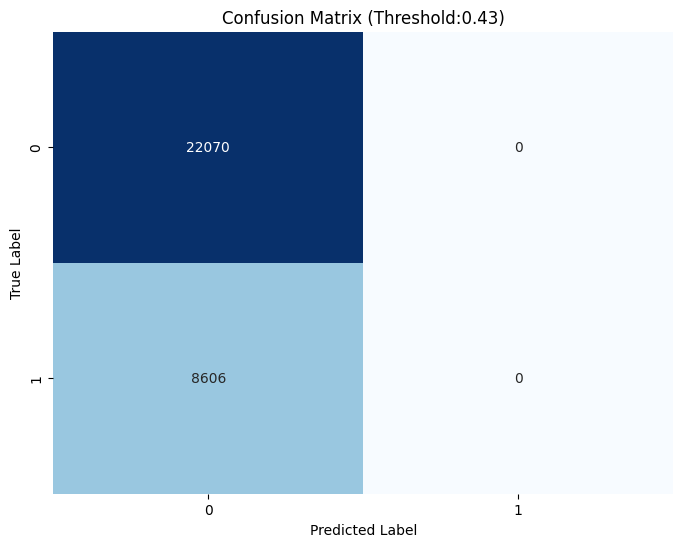

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

predicted_labels = (predictions >= optimal_threshold).astype(int)

cm = confusion_matrix(target, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold:0.43)")
plt.show()


This may be the best threshold when it comes to accuracy, however, when actually trading, how well does the threshold work?

The threshold predicts everything as '0'. While it gets the best accuracy, the goal of this strategy is to capture 1s, and produce the highest return.

## Strategy Building



*   Buy whenever Predicted Value > Threshold Value
*   Sell at SL%, TP%, or end of HP
*   We can be in one position at a time
*   I am assessing performance by:
  *   Sum of Returns
  *   Win Rate
  *   Sharpe Ratio
  *   Average Return

average return


We can grid search different threshold options and see how each trading strategy would perform
Threshold Options: 0.25 - 0.35 with 0.01 intervals

We can do the same for TP and SL options

TP options: 1% - 5% at 1% intervals

SL options: -1% - -5% at 1% intervals

In [ ]:

threshold_values = [i / 100 for i in range(20, 35)]  # 0.3 to 0.7 with 0.01 intervals

take_profit_percents = [i / 100 for i in range(1, 6)]  # 0.01 to 0.05 with 0.01 intervals
stop_loss_percents = [i / 100 for i in range(-5, 0)]  # -0.05 to -0.01 with 0.01 intervals


waiting_period = 15

results = []

   # Loop through different Take Thresholds
for threshold in threshold_values:
    # Loop through different Take Profit percentages
    for take_profit_percent in take_profit_percents:
        # Loop through different Stop Loss percentages
        for stop_loss_percent in stop_loss_percents:
            trade_returns = []
            num_trades = 0
            total_return = 0
            in_position = False
            entry_index = None


            for i in range(len(X_Results)):
                # Check if prediction is above threshold and not currently in a position
                if X_Results['prediction'].iloc[i] > threshold and not in_position:
                    # Buy at the close price
                    entry_price = X_Results['close'].iloc[i]
                    entry_index = i
                    in_position = True
                    num_trades += 1


                elif in_position:
                    # Sell at the close price if take profit or stop loss condition is met or waiting period is over
                    if (X_Results['close'].iloc[i] / entry_price > 1 + take_profit_percent) or \
                       (X_Results['close'].iloc[i] / entry_price < 1 + stop_loss_percent) or \
                       (i - entry_index >= waiting_period):
                        # Calculate trade return
                        trade_return = (X_Results['close'].iloc[i] - entry_price) / entry_price
                        trade_returns.append(trade_return)
                        total_return += trade_return
                        in_position = False

            # Calculate metrics
            avg_return_per_trade = sum(trade_returns) / len(trade_returns) if trade_returns else 0
            sharpe_ratio = avg_return_per_trade / (pd.Series(trade_returns).std() + 1e-6)  # Avoid division by zero
            win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0

            # Store results for this combination of Threshold, Take Profit, and Stop Loss
            results.append({
                'Threshold': threshold,
                'Take Profit Percent': take_profit_percent,
                'Stop Loss Percent': stop_loss_percent,
                'Number of Trades': num_trades,
                'Total Return': total_return,
                'Average Return per Trade': avg_return_per_trade,
                'Sharpe Ratio': sharpe_ratio,
                'Win Rate': win_rate
            })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

In [ ]:
results_df_sorted = results_df.sort_values(by='Total Return', ascending=False)

In [ ]:
results_df_sorted.head(50)

,Threshold,Take Profit Percent,Stop Loss Percent,Number of Trades,Total Return,Average Return per Trade,Sharpe Ratio,Win Rate
35,0.21,0.03,-0.05,2177,2.535744,0.001165,0.041582,0.541360
10,0.20,0.03,-0.05,2177,2.535744,0.001165,0.041582,0.541360
60,0.22,0.03,-0.05,2173,2.380744,0.001096,0.039094,0.539595
55,0.22,0.02,-0.05,2351,2.230999,0.000949,0.035669,0.550638
80,0.23,0.02,-0.05,2084,2.205735,0.001059,0.043563,0.549208
41,0.21,0.04,-0.04,2113,2.185141,0.001035,0.036346,0.526042
16,0.20,0.04,-0.04,2113,2.185141,0.001035,0.036346,0.526042
295,0.31,0.05,-0.05,1239,2.161210,0.001746,0.073669,0.527464
271,0.30,0.05,-0.04,1356,2.143548,0.001582,0.065361,0.531365
147,0.25,0.05,-0.03,1853,2.108202,0.001138,0.044220,0.520518


Checkpoint: results_df_sorted data

In [ ]:
#results_df_sorted.to_csv('/content/drive/MyDrive/Datasets/results_df_sorted.csv', index=False)

In [ ]:
#results_df_sorted = pd.read_csv('/content/drive/MyDrive/Datasets/results_df_sorted.csv')

Based on the results of the simulations, I can infer a few things:

*   Lower thresholds seem to perform well
*   Higher Thresholds ---> Higher Sharpe Ratio, less risk being taken.
*   Higher Thresholds don't always seem to have the highest win rates.






*   In the settings with the top 50 returns, there are some instances of thresholds over 0.30, which may indicate the model is having an impact



## Test Strategy

I will use a threshold of 0.31, TP of 0.05, and Stop Loss of -0.05. This option produced high returns, while also having a higher Sharpe Ratio than the other options

**How good does it do on test_1 data?**

Predictions

In [ ]:
predictions = final_model.predict_proba(X_test_1)[:, 1]
target = Y_test_1
X_Results_test_1 = X_test_1.copy()
X_Results_test_1['prediction'] = predictions
X_Results_test_1['target'] = target

Simulation

In [ ]:
threshold = 0.31
take_profit_percent = 0.05
stop_loss_percent = -0.05
waiting_period = 15

results = []

trade_returns = []
num_trades = 0
total_return = 0
in_position = False
entry_index = None


for i in range(len(X_Results)):
    # Check if prediction is above threshold and not currently in a position
    if X_Results['prediction'].iloc[i] > threshold and not in_position:
        # Buy at the close price
        entry_price = X_Results['close'].iloc[i]
        entry_index = i
        in_position = True
        num_trades += 1


    elif in_position:
        # Sell at the close price if take profit or stop loss condition is met or waiting period is over
        if (X_Results['close'].iloc[i] / entry_price > 1 + take_profit_percent) or \
            (X_Results['close'].iloc[i] / entry_price < 1 + stop_loss_percent) or \
            (i - entry_index >= waiting_period):
            # Calculate trade return
            trade_return = (X_Results['close'].iloc[i] - entry_price) / entry_price
            trade_returns.append(trade_return)
            total_return += trade_return
            in_position = False

# Calculate metrics
avg_return_per_trade = sum(trade_returns) / len(trade_returns) if trade_returns else 0
sharpe_ratio = avg_return_per_trade / (pd.Series(trade_returns).std() + 1e-6)  # Avoid division by zero
win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0

# Store results for this combination of Threshold, Take Profit, and Stop Loss
results.append({
    'Threshold': threshold,
    'Take Profit Percent': take_profit_percent,
    'Stop Loss Percent': stop_loss_percent,
    'Number of Trades': num_trades,
    'Total Return': total_return,
    'Average Return per Trade': avg_return_per_trade,
    'Sharpe Ratio': sharpe_ratio,
    'Win Rate': win_rate
})

# Create a DataFrame from the results
results_test_1_df = pd.DataFrame(results)

In [ ]:
results_test_1_df

,Threshold,Take Profit Percent,Stop Loss Percent,Number of Trades,Total Return,Average Return per Trade,Sharpe Ratio,Win Rate
0,0.31,0.05,-0.05,1239,2.16121,0.001746,0.073669,0.527464


# Summary

There are various conclusions that can be made for this strategy,

*   Train/Test Performance
  *   I found an optimal threshold for the model prediction to be 0.31, with TP of 5% and SL of -5%
  *   Based on this strategy, we achieved over 200% return on the test data over less than a year.
  *   The train data achieved a 250% return on it's best thresholds, however that was over more than 3 years
  *   The average return per trade on the TEST data was 0.0017. While low, a positive return is a good sign
  *   The Sharpe Ratio of 0.074 when testing and training the strategy is concerning. While we achieve great returns, it seems the risk to reward ratio is off. A Sharpe Ratio greater than 1 is seen as positive.


*   Potential Edits
  *   Although the Target variable seemed more realistic than my initial thought of using 98th Percentile Returns, more research could be done into the range of returns that are achieved. It seems the model predicted many small returns
  *   More features could be added to this model to make it more robust. Perhaps more features capturing the recent trends in return
  *  My strategy can only be in one position at once, and only tries 5 different Stop Loss and Take Profit thresholds. Additionally, I could try more thresholds for my prediction probabilities



